In [16]:
import numpy as np
import nnfs
from nnfs.datasets import vertical_data
import matplotlib.pyplot as plt
from timeit import timeit

In [3]:
nnfs.init()

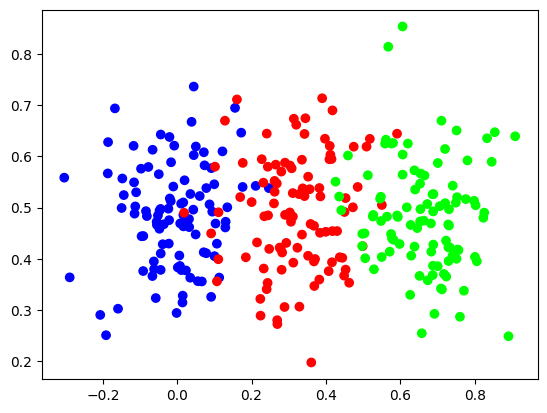

In [27]:
X, y = vertical_data(samples=100, classes=3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg')
plt.show()

In [69]:
class Layer_Dense:
    # Layer initialization
    def __init__(self, n_inputs, n_neurons) -> None:
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

        """
        [[1, 2],
         [3, 4],
         [5, 6]]
        """

    # forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs

        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases
        pass

    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradients on values
        self.dinputs = np.dot(dvalues, self.weights.T)

In [40]:
class Activation_ReLU:
    # Forward pass
    def forward(self, inputs):
        # Remember inputs for backward pass
        self.inputs = inputs

        self.output = np.maximum(0, inputs)
    
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()

        # Zero gradient where iunput values were negative
        self.dinputs[self.inputs <= 0] = 0

In [44]:
class Activation_Softmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

    def backward (self, dvalues):

        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix =  np.diagflat(single_output) - np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

In [46]:
class Loss:
    def calculate(self, output, truth):
        sample_losses = self.forward(output, truth)

        data_loss = np.mean(sample_losses)

        return data_loss

In [45]:
class Loss_CategoricalCrossEntropy(Loss):     
    def forward(self, output, truth):
        clipped_output = np.clip(output, 1e-7, 1 - 1e-7)

        # Output should be an array of prediction arrays. Truth can either be a an array of indexes to query for loss, or a matrix of equal size with ground truths
        if (len(truth.shape) == 1):
            correct_confidences = clipped_output[range(len(clipped_output)), truth]
            losses = -np.log(correct_confidences)
            mean_loss = np.mean(losses)
            return mean_loss

        elif (len(truth.shape) == 2):
            correct_confidences = np.sum(clipped_output * truth, axis=1)
            losses = -np.log(correct_confidences)
            mean_loss = np.mean(losses)
            return mean_loss
        
    def backward(self, predicted_values, y_true):

        # Number of samples
        samples = len(predicted_values)
        # Number of labels in every sample
        labels = len(predicted_values[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / predicted_values
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [48]:
class Activation_Softmax_Loss_CategoricalCrossEntropy():

    def __init__(self) -> None:
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossEntropy()

    def forward(self, inputs, y_truth):
        self.activation.forward(inputs=inputs)

        self.output = self.activation.output

        return self.loss.calculate(self.output, y_truth)

    def backward(self, predicted_values, y_true):
        # Number of samples
        samples = len(predicted_values)

        # If labels are one-hot encoded, turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        # Copy to safely modify
        self.dinputs = predicted_values.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [49]:
activationAndLoss = Activation_Softmax_Loss_CategoricalCrossEntropy()

softmax_outputs = np.array([[0.7, 0.1, 0.2],
                            [0.1, 0.5, 0.4],
                            [0.02, 0.9, 0.08]])

class_targets = np.array([0, 1, 1])

# Direct loss gradient w.r.t softmax inputs
def f1():
    activationAndLoss.backward(softmax_outputs, class_targets)
    dvalues1 = activationAndLoss.dinputs

# Getting gradient w.r.t softmax inputs through Jacobian matrix
def f2():
    activation = Activation_Softmax()
    activation.output = softmax_outputs
    loss = Loss_CategoricalCrossEntropy()
    loss.backward(activation.output, class_targets)
    activation.backward(loss.dinputs)
    dvalues2 = activation.dinputs


t1 = timeit(f1, number=10000)
t2 = timeit(f2, number=10000)

print(t2/t1)


6.393322817207645


In [77]:
# Create dense layer with 2 input features and 3 output values
dense1 = Layer_Dense(2, 3)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 3 input features and 3 output values
dense2 = Layer_Dense (3, 3)

# Create softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossEntropy()

# Perform a forward pass through the first layer
dense1.forward(X)

# Perform a forward pass through the activation function, takes the output of the first dense layer
activation1.forward(dense1.output)

# Perform a forward pass through the second Dense layer, takes outputs of activation function of first layer as input
dense2.forward(activation1.output)

# Perform a forward pass throuhgh the activation and loss function. Takes output of the second dense layer and returns loss
loss = loss_activation.forward(dense2.output, y)


# First few predictions
print(loss_activation.output[:5])
# Loss value
print('loss', loss)

# Calculate accuracy from output of activation2 and targets
# calculate values along first axis
predictions = np.argmax(loss_activation.output, axis=1)
if len(y.shape) == 2:
    y = np.argmax(y, axis = 1)
accuracy = np.mean(predictions == y)
print('accuracy:', accuracy)

# Backward pass
loss_activation.backward(loss_activation.output, y)
dense2.backward(loss_activation.dinputs)
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)

# Print gradients
print(dense1.dweights)
print(dense1.dbiases)
print(dense2.dweights)
print(dense2.dbiases)

[[0.3333325  0.33333468 0.33333275]
 [0.33331564 0.33334732 0.33333704]
 [0.33329585 0.33336225 0.3333419 ]
 [0.33330733 0.33335355 0.33333915]
 [0.33332148 0.33334282 0.3333357 ]]
loss 1.098573
accuracy: 0.35
[[ 1.2103457e-03 -5.1738270e-06 -1.9662008e-03]
 [ 3.3505221e-06 -1.4451600e-06 -9.2970848e-05]]
[[-5.6717545e-07 -5.8069772e-06 -2.3636369e-04]]
[[ 9.1485726e-04  5.2544701e-06 -9.2011178e-04]
 [ 9.8796295e-07  9.8847272e-07 -1.9764357e-06]
 [ 2.7058695e-03  3.5939785e-05 -2.7418092e-03]]
[[-4.6957750e-05  3.5713310e-05  1.1296244e-05]]
